In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from ADM import ADM

from data_loader import load_pickle, unpack_data
from mutual_information import (
    compute_mutual_information,
    create_spectrogram,
    to_spikes_and_back,
    first_order_low_pass
)
sns.set()

SUBJECT_IDX = 9

In [13]:
dataset = load_pickle(SUBJECT_IDX)

### Create spectrogram of PPG signal

<ipython-input-14-5a7ad3562cde>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


Text(0.5, 0, 'Time [s]')

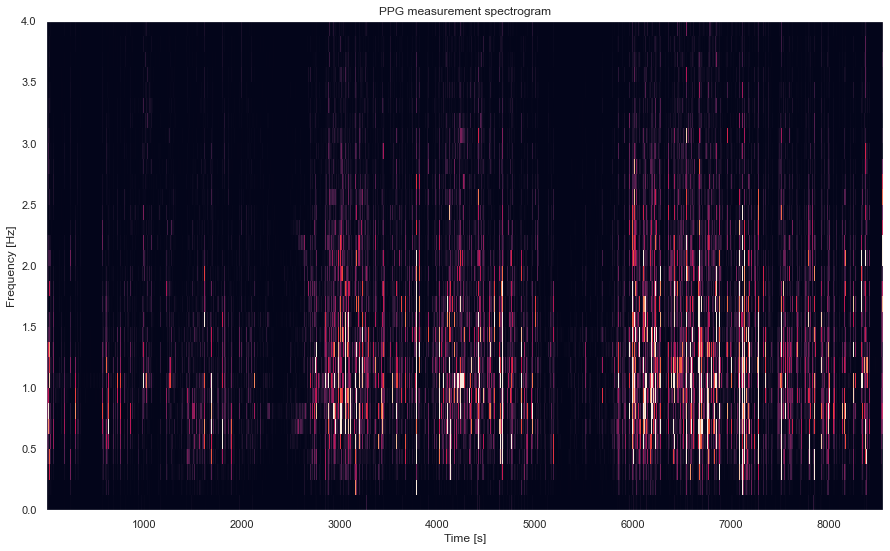

In [14]:
fs_ppg = 64
nperseg_ppg = 8 * 64
noverlap = 6 * 64
fmin = 0 # Hz
fmax = 4 # Hz

ppg, acc, hr, activity, _= unpack_data(dataset)

hr_timestamps = np.arange(4, len(hr) * 2 + 4, 2)
hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

### create spectrogram
f_ppg, t_ppg, Sxx_ppg = create_spectrogram(ppg, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_ppg)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

### Run PPG through ADM

In [43]:
ADM_factor = 0.2
ADM_step_size = ADM_factor * np.mean(abs(ppg))
up_spikes, down_spikes = ADM(
    ppg,
    up_threshold=ADM_step_size,
    down_threshold=ADM_step_size,
    sampling_rate=fs_ppg,
    refractory_period=0
)

In [44]:
(len(up_spikes) + len(down_spikes)) / len(ppg) * 64

22.407359813084113

### Reconstruct original signal from ADM-generated spike train using gaussian kernel

In [45]:
def reconstruct_from_spikes(spikes, length, spike_value):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    reconstructed_signal = gaussian_filter1d(reconstructed_signal, 10)
    return reconstructed_signal

In [46]:
reconstructed_signal = (
    reconstruct_from_spikes(up_spikes, len(ppg), 1) +
    reconstruct_from_spikes(down_spikes, len(ppg), -1)
)

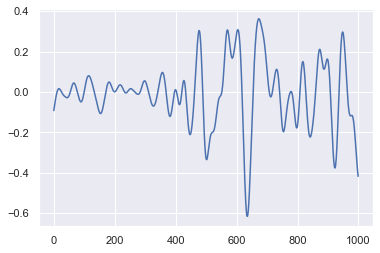

In [47]:
plot_segment_start = 100000
plot_segment_length = 1000
plt.plot(reconstructed_signal[plot_segment_start:plot_segment_start+plot_segment_length])

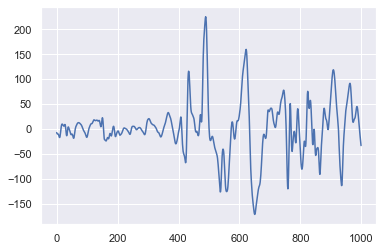

In [48]:
plt.plot(ppg[plot_segment_start:plot_segment_start+plot_segment_length])

### Create spectrogram of reconstructed signal

<ipython-input-49-60e36cf43055>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')


Text(0.5, 0, 'Time [s]')

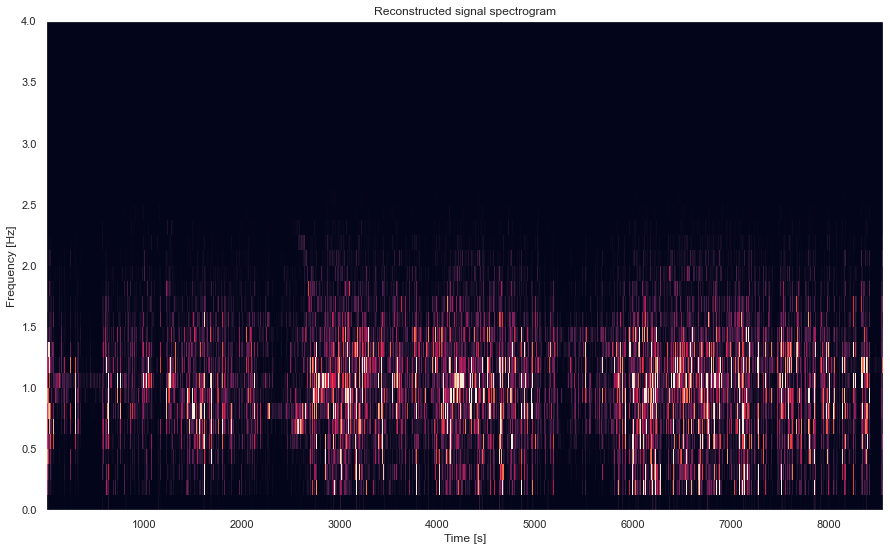

In [49]:
### create spectrogram
f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

### interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_rec)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')
plt.title('Reconstructed signal spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

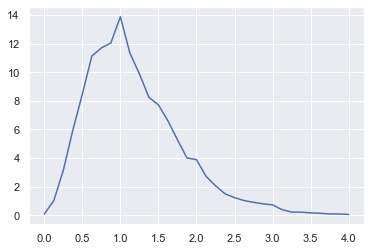

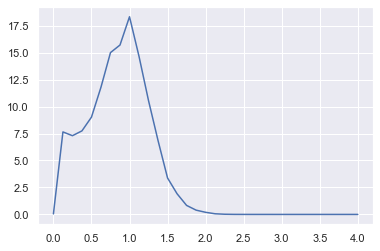

In [50]:
plt.plot(f_ppg, Sxx_ppg.var(axis=1))
plt.show()
plt.plot(f_rec, Sxx_rec.var(axis=1))

### Mutual information

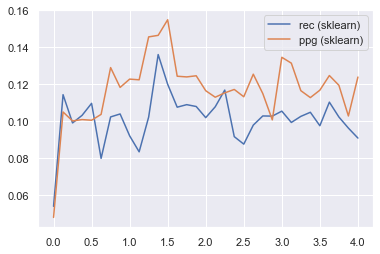

In [51]:
n_neighbors = 10
num_hr_bins = 15
num_power_bins = 6
mutual_info_rec = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_rec_sklearn = mutual_info_regression(np.transpose(Sxx_rec), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
mutual_info_ppg = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_ppg_sklearn = mutual_info_regression(np.transpose(Sxx_ppg), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
#plt.plot(f_ppg, mutual_info_ppg, label='ppg')
#plt.plot(f_rec, mutual_info_rec, label='rec')
plt.plot(f_rec, mutual_info_rec_sklearn, label='rec (sklearn)')
plt.plot(f_ppg, mutual_info_ppg_sklearn, label='ppg (sklearn)')
plt.legend()